<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Data-analysis" data-toc-modified-id="Data-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data analysis</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span></li></ul></div>

# Recovery of gold from ore

Prepare a prototype of a machine learning model for [Zyphra](https://www.zyfra.com/). The company develops solutions for the efficient operation of industrial enterprises.

The model must predict the recovery rate of gold from gold ore. Use data with mining and purification parameters.

The model will help optimize production so as not to launch an enterprise with unprofitable characteristics.

You need:

1. Prepare data;
2. Conduct exploratory data analysis;
3. Build and train the model.

## Data preparation

In [54]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy import stats as st

In [5]:
df = pd.read_csv('gold_recovery_full_new.csv')
train = pd.read_csv('gold_recovery_train_new.csv')
test = pd.read_csv('gold_recovery_test_new.csv')

In [6]:
df.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


The main file has 87 columns, of which 2 recovery columns are targets and a date column. The remaining 84 columns are potential features that can be used for training. 19439 observations in total

In [8]:
pd.DataFrame(round(df.isna().mean().mul(100), 3)).style.background_gradient('viridis')

,0
date,0.000000
final.output.concentrate_ag,0.005000
final.output.concentrate_pb,0.005000
final.output.concentrate_sol,1.085000
final.output.concentrate_au,0.000000
final.output.recovery,0.000000
final.output.tail_ag,0.005000
final.output.tail_pb,0.520000
final.output.tail_sol,0.031000
final.output.tail_au,0.000000


There are missing data in several columns, which typically account for no more than 1% of observations

In [9]:
df['date'] = pd.to_datetime(df['date'])

In [10]:
df = df.sort_values(by='date')

In [11]:
df = df.fillna(method='ffill')
df.isna().sum().sum()

0

In [12]:
df.duplicated().sum()

0

From the code below you can see that there are null values in the recovery columns. This may affect the sMAPE metric in the future, since you cannot divide by zero

In [13]:
pd.set_option('display.max_rows', None)
pd.DataFrame(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
final.output.concentrate_ag,19439.0,5.168387,1.372362,0.000000e+00,4.251000,5.066039,5.895401,1.600195e+01
final.output.concentrate_pb,19439.0,9.978821,1.669228,0.000000e+00,9.137225,10.102264,11.035644,1.703190e+01
final.output.concentrate_sol,19439.0,9.429902,2.865629,0.000000e+00,7.662953,9.184826,10.920957,1.961572e+01
final.output.concentrate_au,19439.0,44.076513,5.129784,0.000000e+00,43.402215,45.011244,46.275313,5.275664e+01
final.output.recovery,19439.0,67.050208,10.125840,0.000000e+00,63.299712,68.172738,72.686642,1.000000e+02
final.output.tail_ag,19439.0,9.688487,2.328624,0.000000e+00,8.062715,9.743106,11.134242,1.955215e+01
final.output.tail_pb,19439.0,2.694897,0.958836,0.000000e+00,2.027553,2.743965,3.329206,5.804178e+00
final.output.tail_sol,19439.0,10.582894,2.868996,0.000000e+00,8.937983,10.622340,12.104122,2.231773e+01
final.output.tail_au,19439.0,3.042467,0.922808,0.000000e+00,2.461138,2.984909,3.571351,8.245022e+00
primary_cleaner.input.sulfate,19439.0,144.542451,44.593704,3.111820e-03,114.051097,143.205708,175.035538,2.659831e+02


In [14]:
df.loc[(df['rougher.output.recovery']==0) | (df['final.output.recovery'] == 0), 
       ['date', 'rougher.output.recovery', 'final.output.recovery']]

,date,rougher.output.recovery,final.output.recovery
45,2016-01-16 21:00:00,0.000000,68.403877
46,2016-01-16 22:00:00,0.000000,70.675633
47,2016-01-16 23:00:00,0.000000,55.088448
48,2016-01-17 00:00:00,0.000000,41.962008
49,2016-01-17 02:00:00,0.000000,49.884856
50,2016-01-17 03:00:00,0.000000,68.638723
51,2016-01-17 04:00:00,0.000000,72.136712
644,2016-02-13 11:00:00,68.960993,0.000000
759,2016-02-18 20:00:00,0.000000,80.041038
1193,2016-03-11 10:00:00,82.787322,0.000000


In [15]:
((df['rougher.output.recovery']==0) | (df['final.output.recovery'] == 0)).sum()

490

Below is a check for multicollinearity, which can be a problem for linear regression. Next, we will try the random forest model.

C:\Users\albin\AppData\Local\Temp\ipykernel_50612\2281433658.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),
C:\Users\albin\AppData\Local\Temp\ipykernel_50612\2281433658.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask=np.triu(np.ones_like(df.corr())),


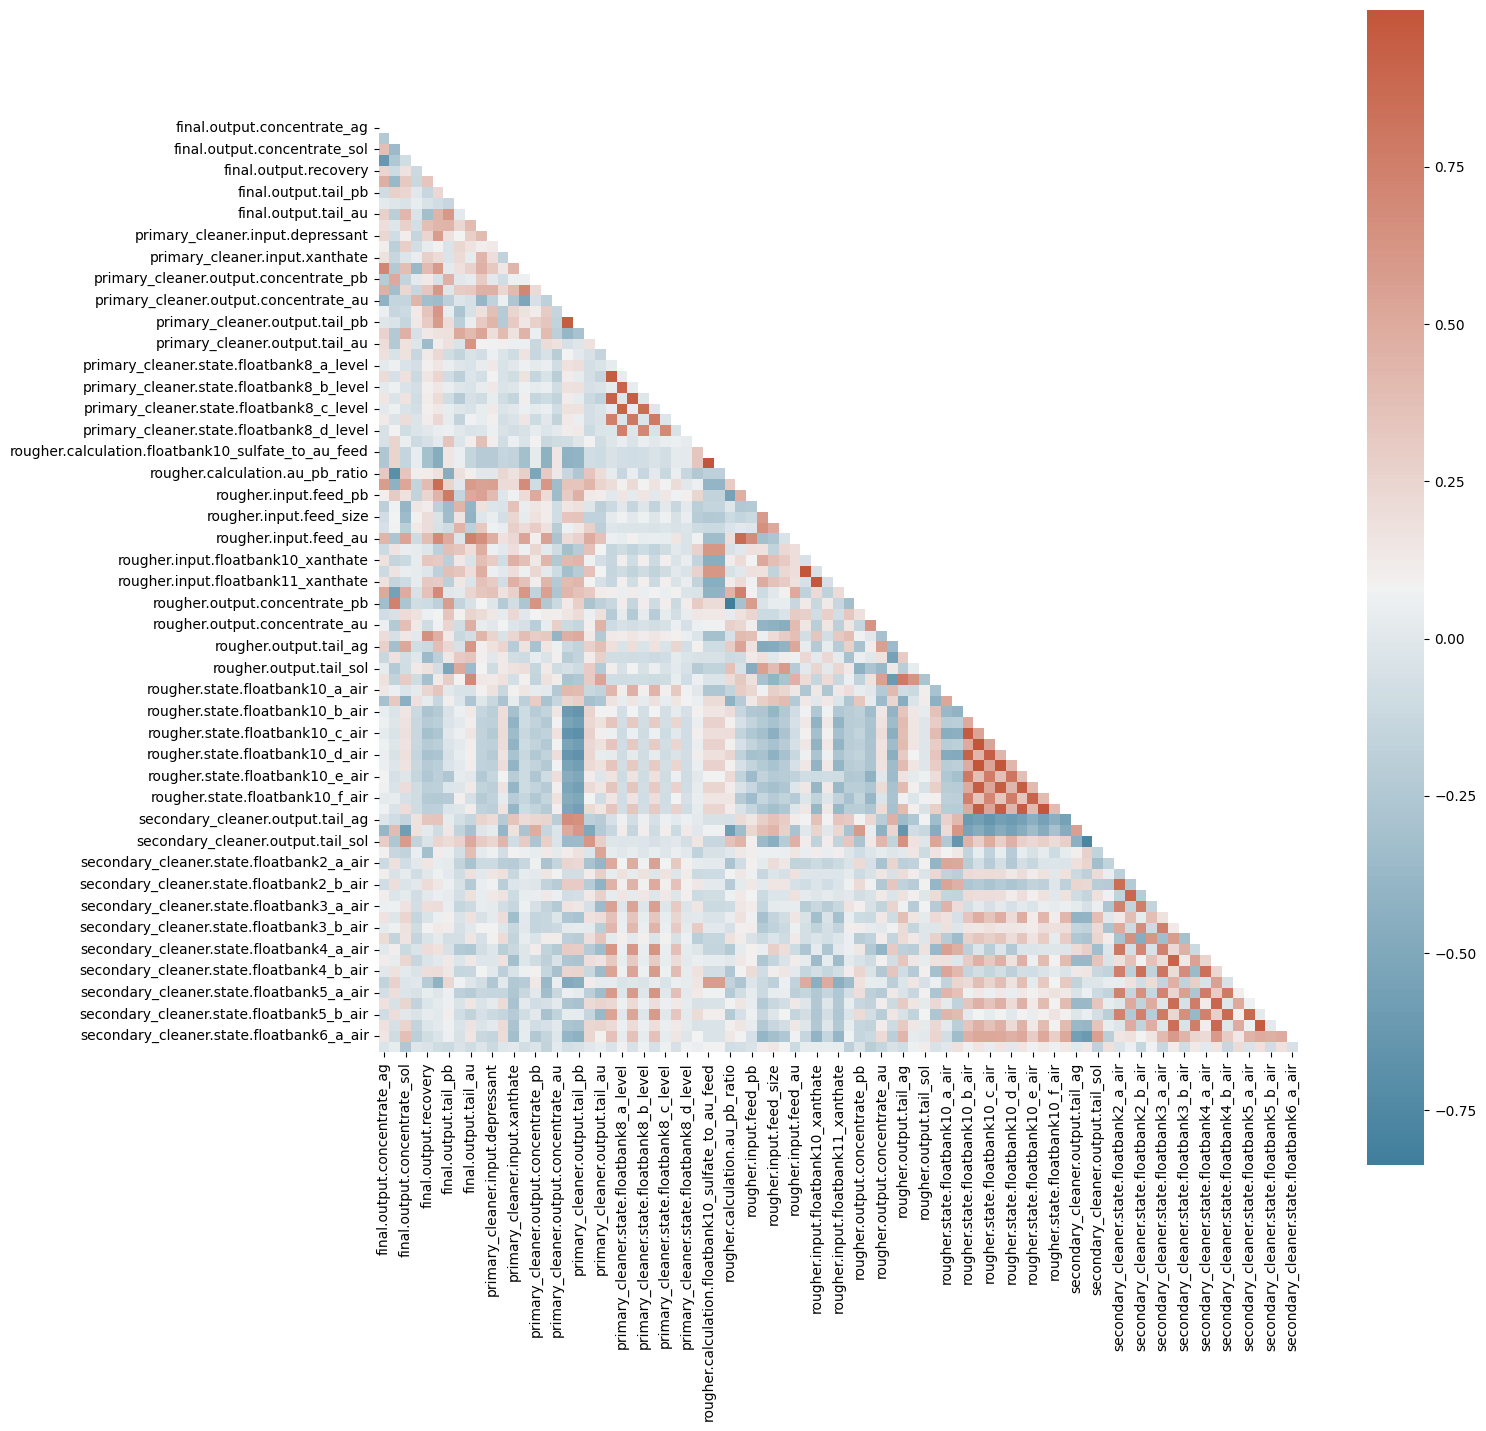

In [47]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), 
            mask=np.triu(np.ones_like(df.corr())), 
            cmap=sns.diverging_palette(230, 20, as_cmap=True), 
            square=True);

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [18]:
train['input'] = 1 - train['rougher.output.tail_au']/train['rougher.input.feed_au']
train['output'] = 1 - train['rougher.output.tail_au']/train['rougher.output.concentrate_au']
train['recovery'] = train['input']/train['output'] * 100
round(mean_absolute_error(train['rougher.output.recovery'], train['recovery']))

0

In [19]:
train['recovery'] = (train['rougher.output.concentrate_au'] * 
                     (train['rougher.input.feed_au'] - train['rougher.output.tail_au']) / (
                         train['rougher.input.feed_au'] * (
                             train['rougher.output.concentrate_au'] - train['rougher.output.tail_au']))) * 100

round(mean_absolute_error(train['rougher.output.recovery'], train['recovery']), 1)

0.0

The discrepancy between the _recovery_ metric given in the dataset and the calculated metric is minimal

In [20]:
train.drop(columns=['input', 'output', 'recovery'], inplace=True)

The recovery metric is calculated correctly

In [21]:
train['date'] = pd.to_datetime(train['date'])

In [22]:
pd.DataFrame(train.isna().mean().mul(100)).style.background_gradient('viridis')

,0
date,0.000000
final.output.concentrate_ag,0.007068
final.output.concentrate_pb,0.007068
final.output.concentrate_sol,1.491271
final.output.concentrate_au,0.000000
final.output.recovery,0.000000
final.output.tail_ag,0.000000
final.output.tail_pb,0.706764
final.output.tail_sol,0.035338
final.output.tail_au,0.000000


In [23]:
train = train.sort_values(by='date')

In [24]:
train = train.fillna(method='ffill')

In [25]:
train.duplicated().sum()

0

In [26]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [27]:
test['date'] = pd.to_datetime(test['date'])

In [28]:
test = test.sort_values(by='date')

In [29]:
pd.DataFrame(test.isna().mean().mul(100)).style.background_gradient('viridis')

,0
date,0.000000
primary_cleaner.input.sulfate,0.075614
primary_cleaner.input.depressant,0.094518
primary_cleaner.input.feed_size,0.000000
primary_cleaner.input.xanthate,0.075614
primary_cleaner.state.floatbank8_a_air,0.000000
primary_cleaner.state.floatbank8_a_level,0.000000
primary_cleaner.state.floatbank8_b_air,0.000000
primary_cleaner.state.floatbank8_b_level,0.000000
primary_cleaner.state.floatbank8_c_air,0.000000


In [30]:
test = test.fillna(method='ffill')

In [31]:
test.duplicated().sum()

0

In [32]:
columns = list(set(train.columns)-set(test.columns))
columns.remove('rougher.output.recovery')
columns.remove('final.output.recovery')
columns

['rougher.output.tail_pb',
 'secondary_cleaner.output.tail_pb',
 'primary_cleaner.output.concentrate_sol',
 'final.output.tail_au',
 'rougher.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'secondary_cleaner.output.tail_sol',
 'final.output.tail_pb',
 'rougher.calculation.au_pb_ratio',
 'final.output.concentrate_ag',
 'final.output.concentrate_sol',
 'secondary_cleaner.output.tail_au',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_pb',
 'rougher.output.tail_sol',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'final.output.tail_sol',
 'primary_cleaner.output.tail_pb',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.output.tail_au',
 'final.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'final.output.concentrate_pb',
 'rougher.output.tail_ag',
 'rougher.output.conce

Since the training will not need those features that are not in the test sample, they will have to be removed. These features are mainly associated with added chemicals and their residues during gold ore refining. Features such as lead residue after cleaning are unlikely to influence predicted targets. Other _product parameters_, on the contrary, can lead to data leakage. There are also _calculated characteristics_ that are unnecessary for the model.

In [33]:
train.drop(columns=columns, inplace=True)

In [34]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 14148
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        14149 non-null  datetime64[ns]
 1   final.output.recovery                       14149 non-null  float64       
 2   primary_cleaner.input.sulfate               14149 non-null  float64       
 3   primary_cleaner.input.depressant            14149 non-null  float64       
 4   primary_cleaner.input.feed_size             14149 non-null  float64       
 5   primary_cleaner.input.xanthate              14149 non-null  float64       
 6   primary_cleaner.state.floatbank8_a_air      14149 non-null  float64       
 7   primary_cleaner.state.floatbank8_a_level    14149 non-null  float64       
 8   primary_cleaner.state.floatbank8_b_air      14149 non-null  float64       
 9   primar

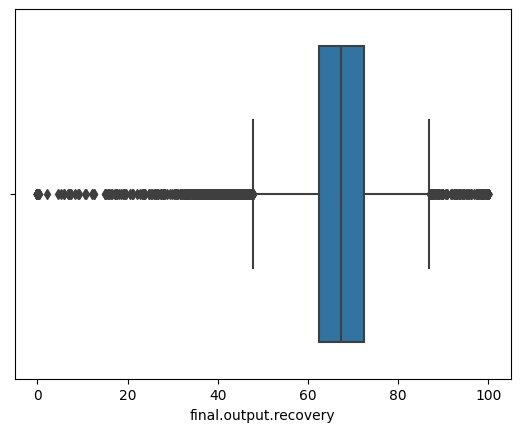

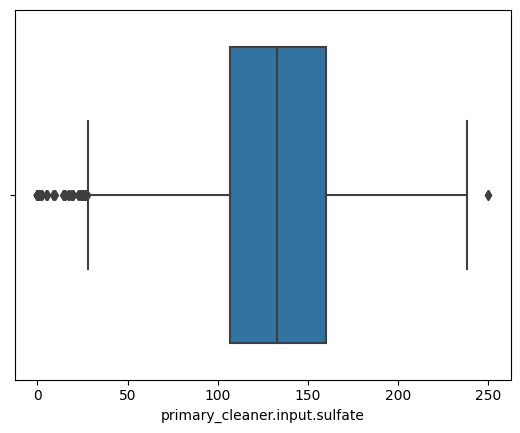

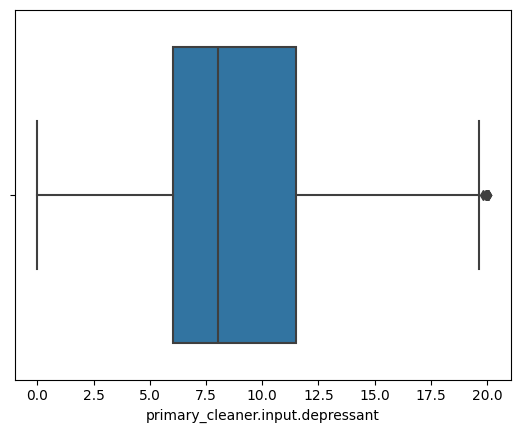

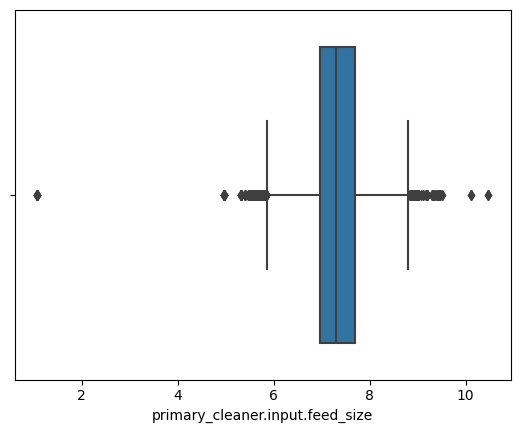

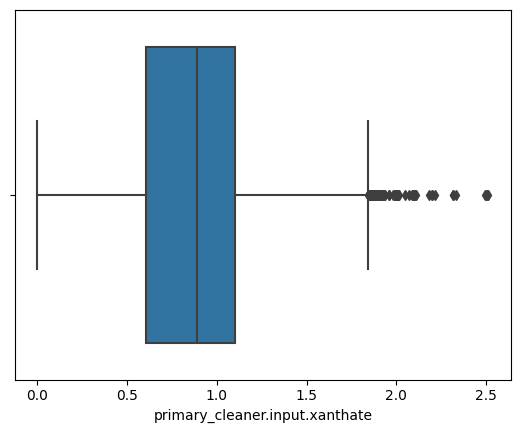

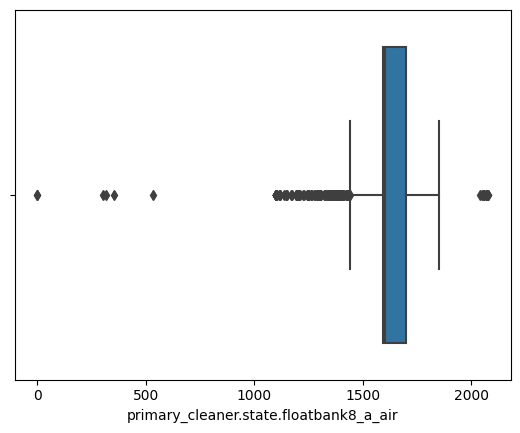

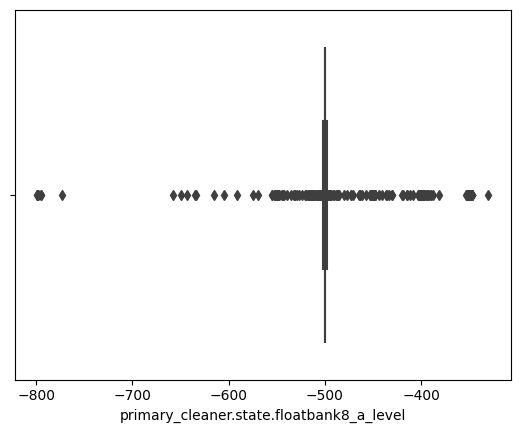

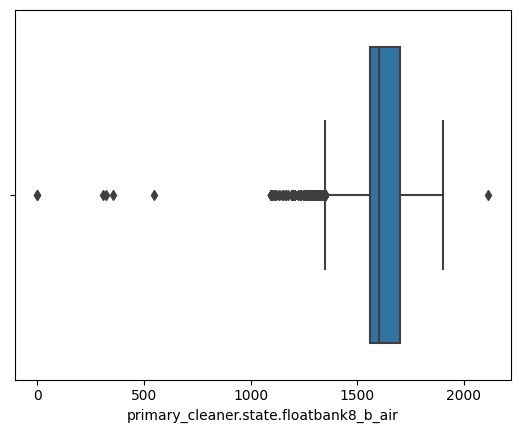

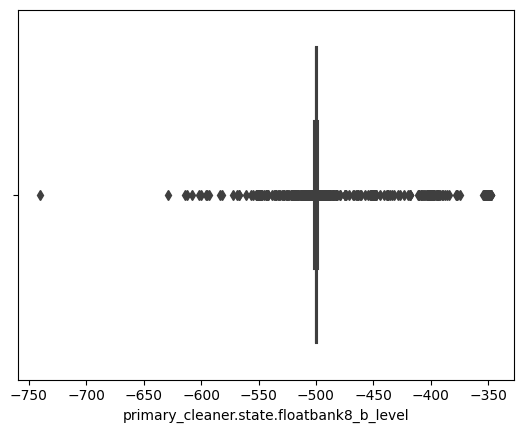

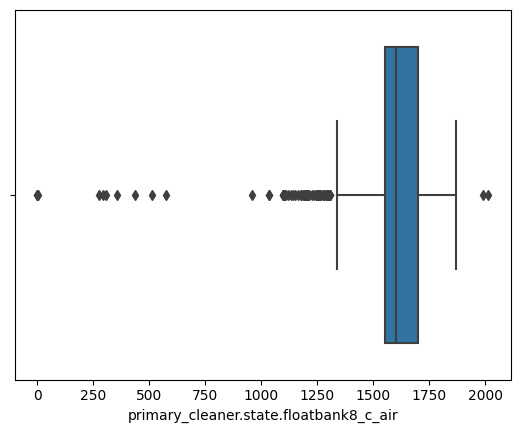

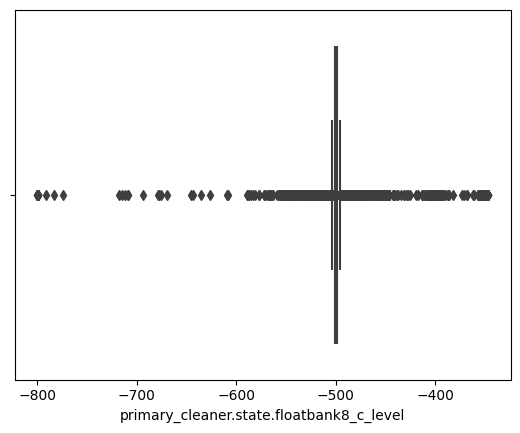

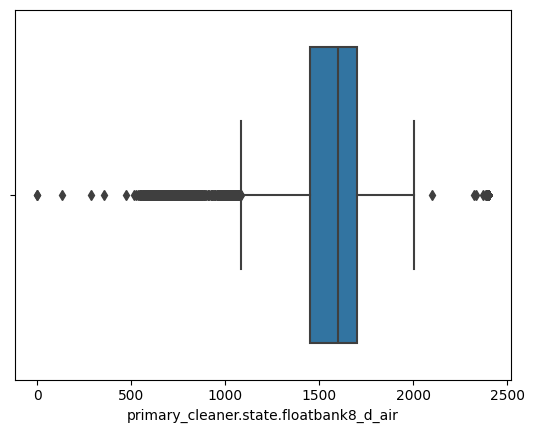

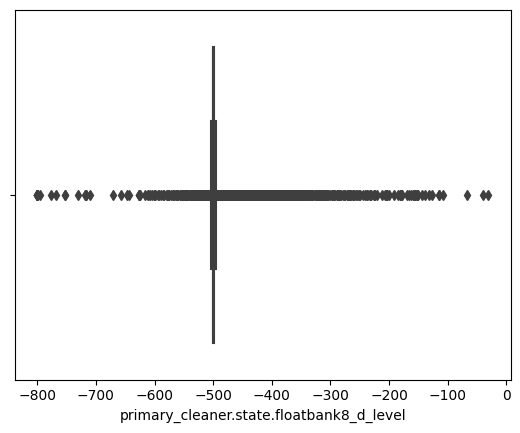

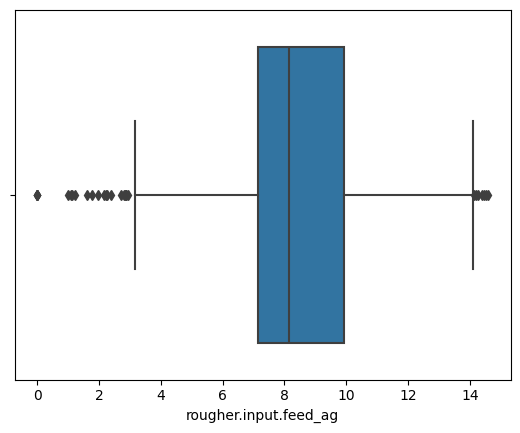

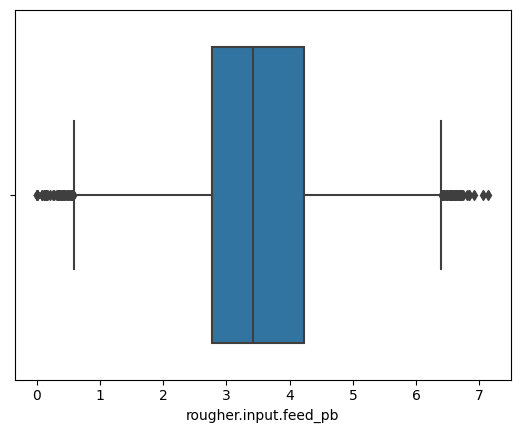

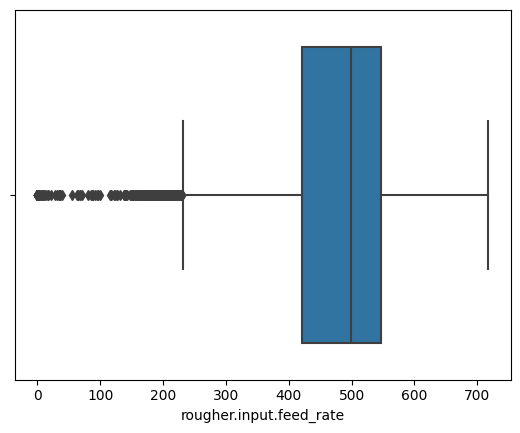

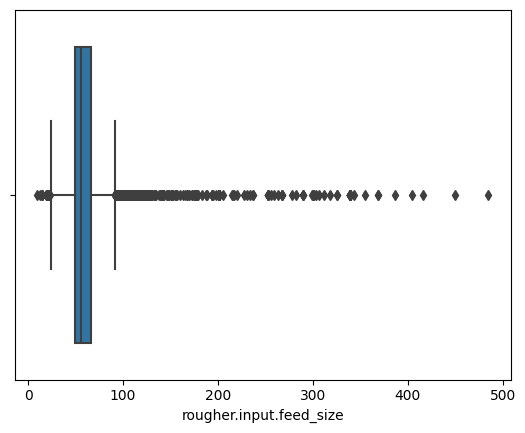

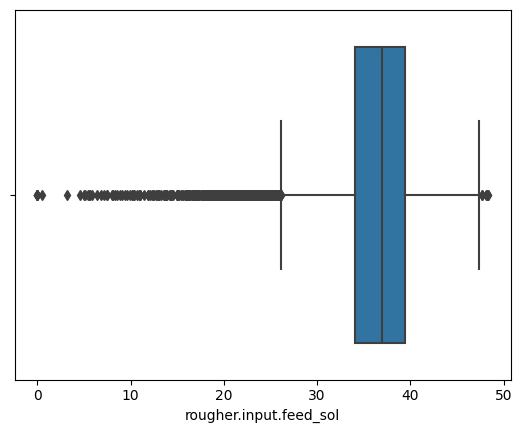

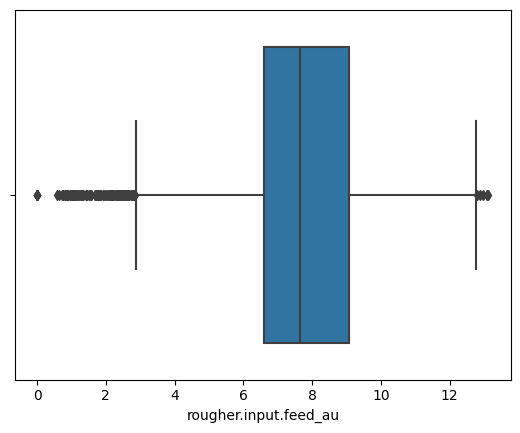

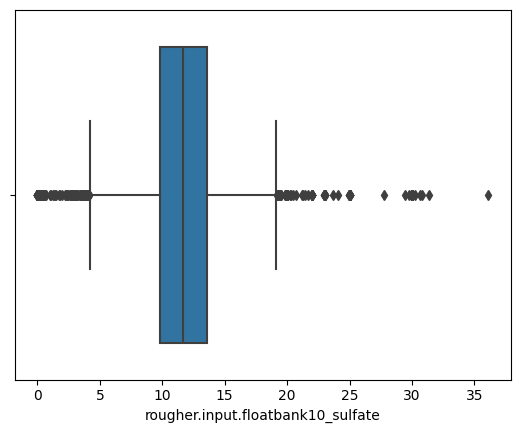

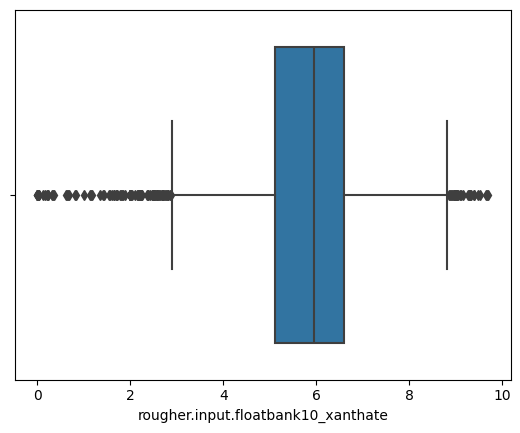

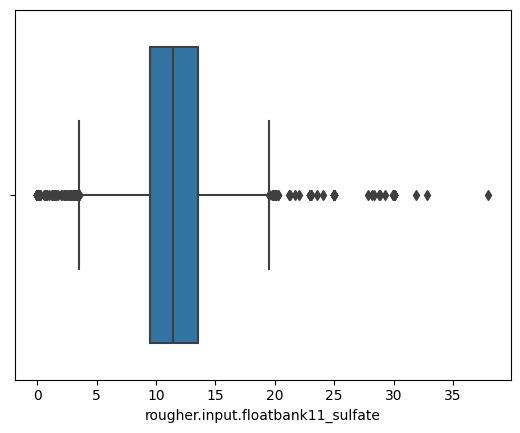

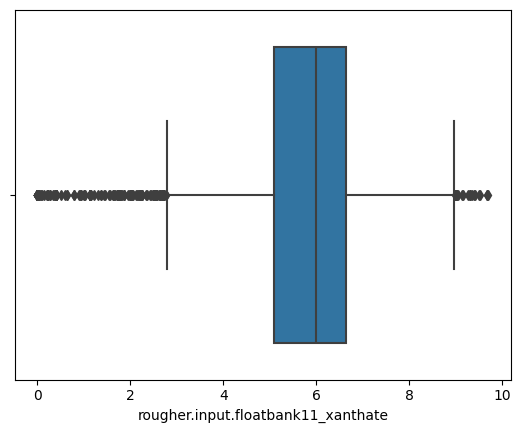

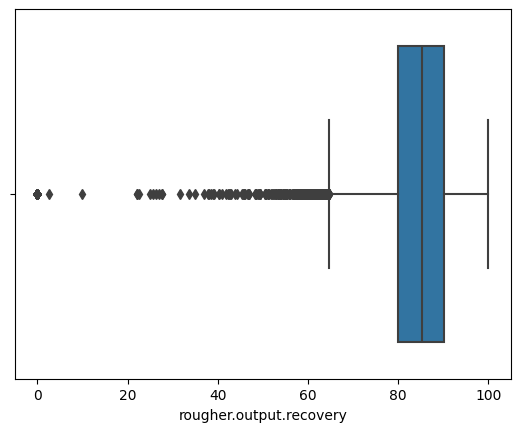

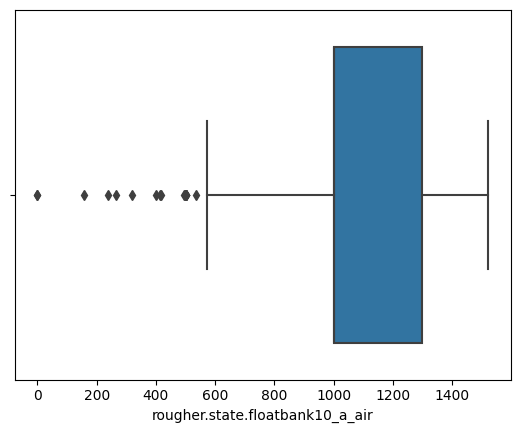

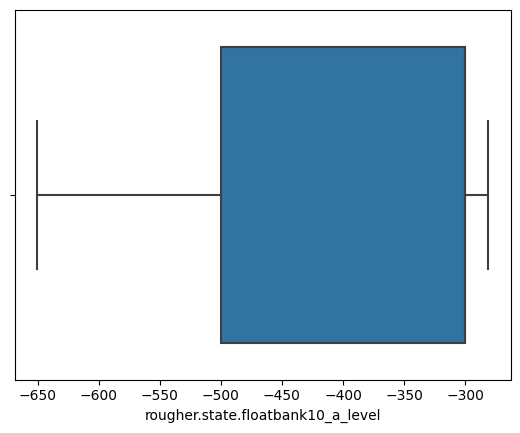

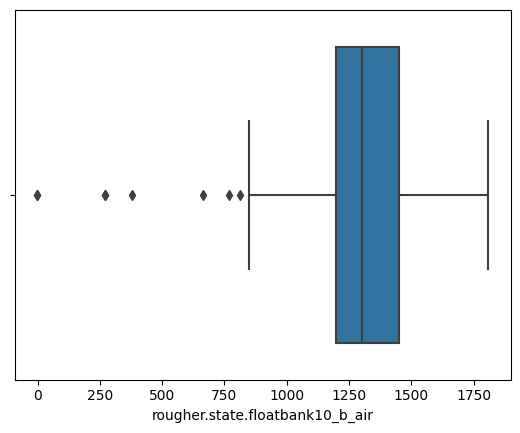

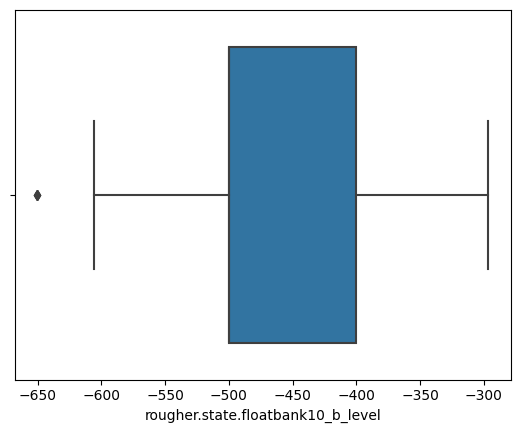

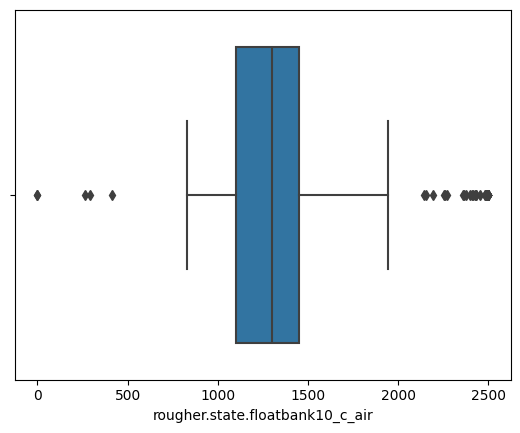

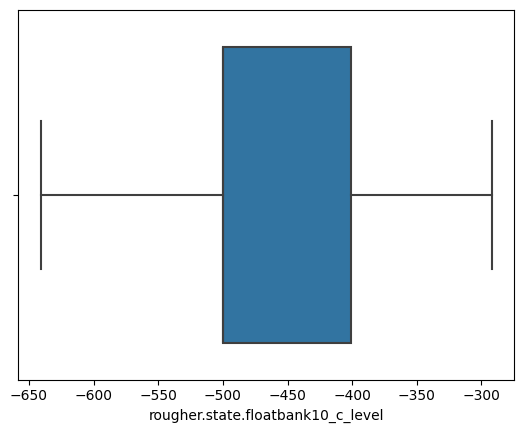

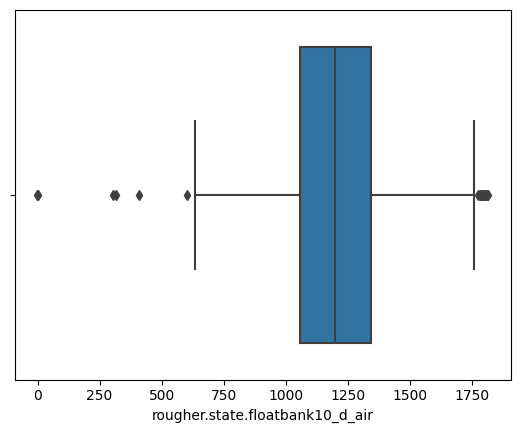

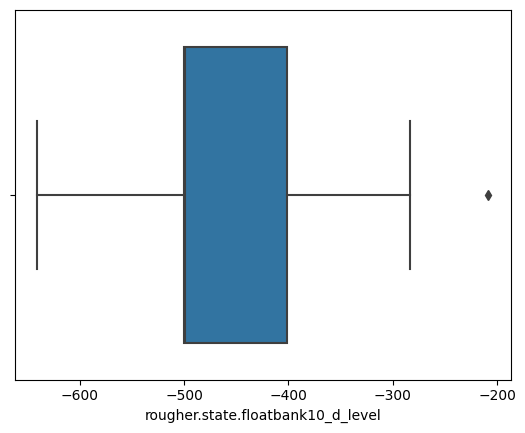

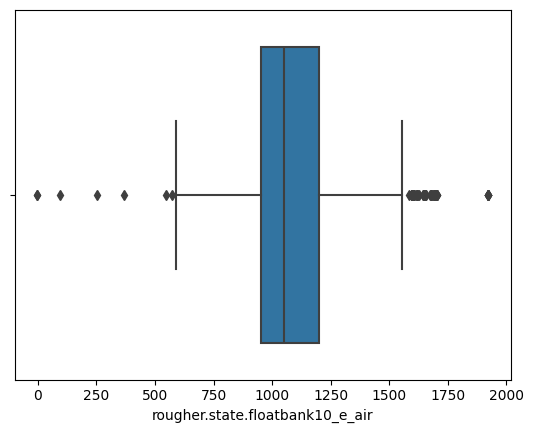

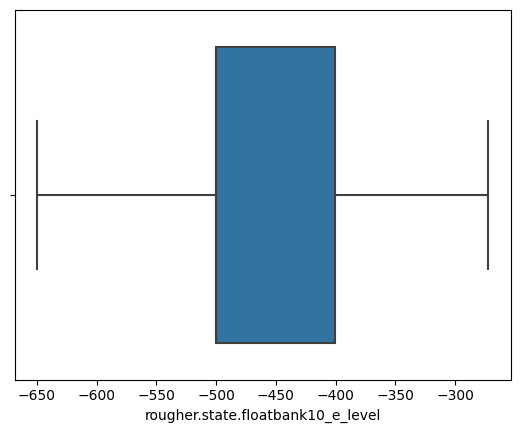

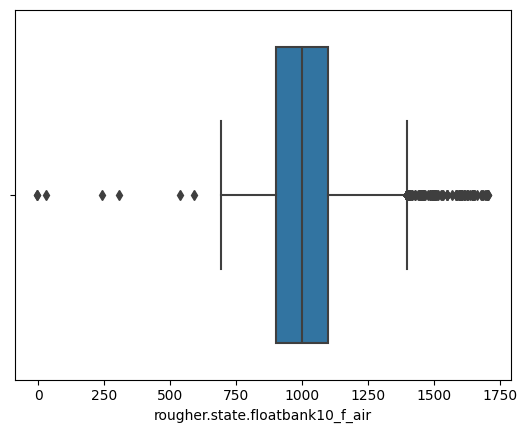

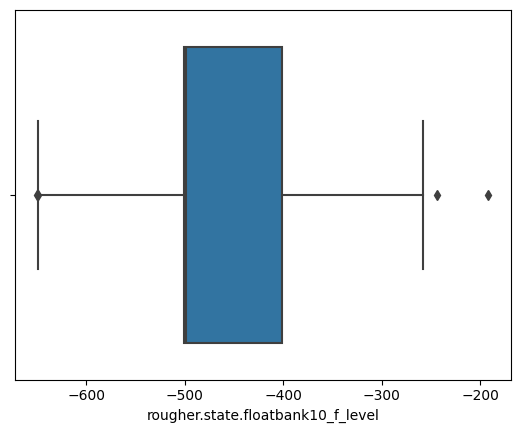

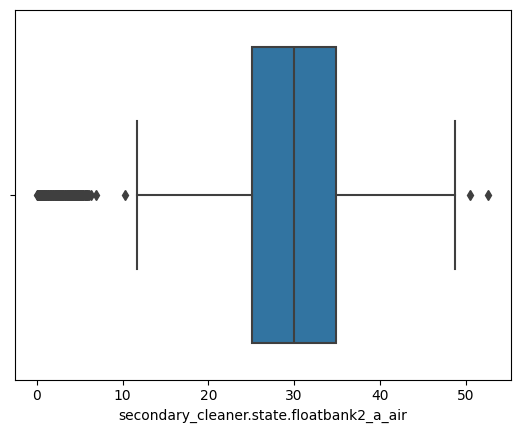

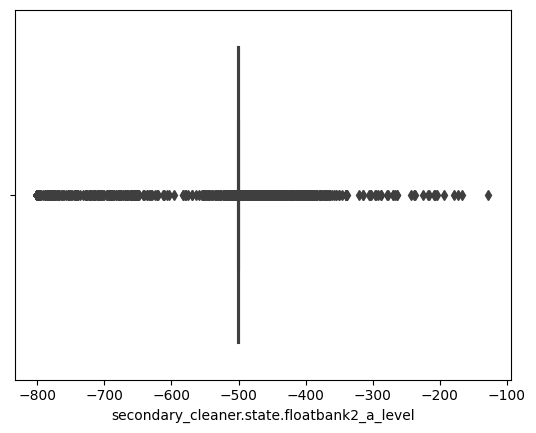

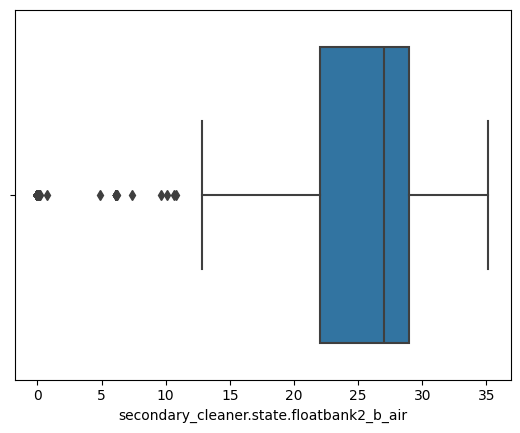

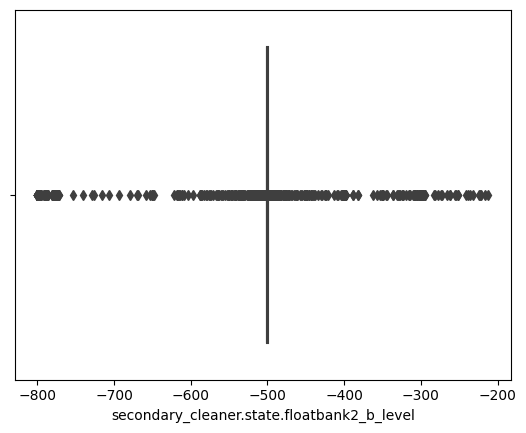

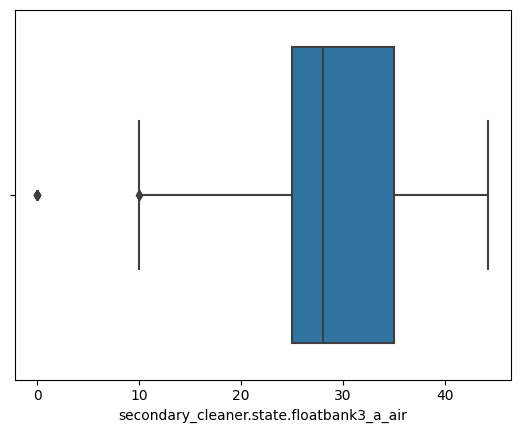

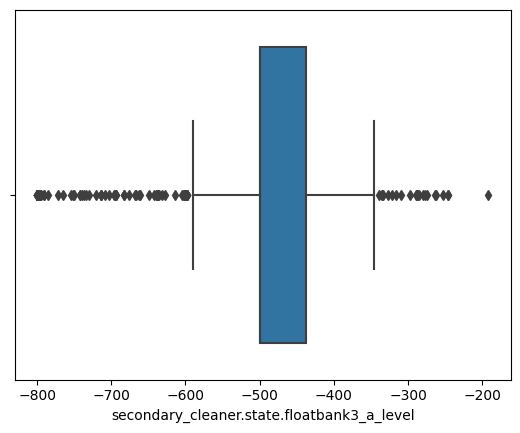

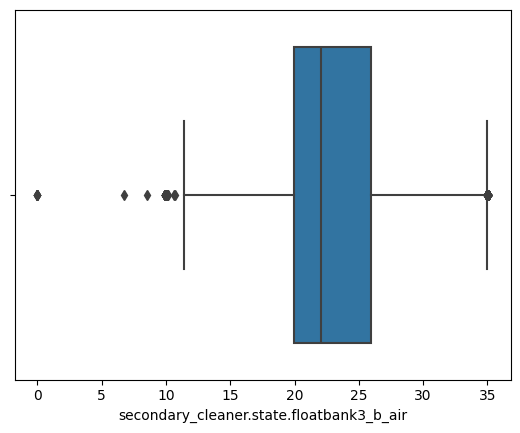

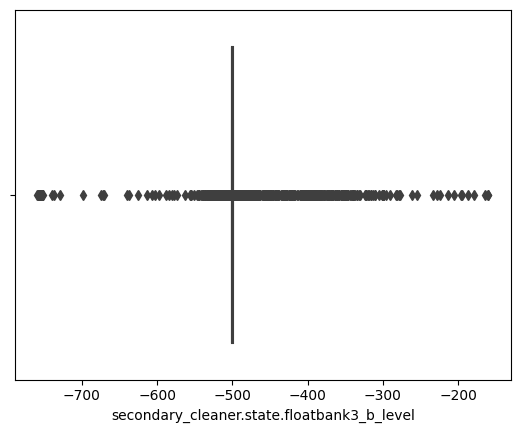

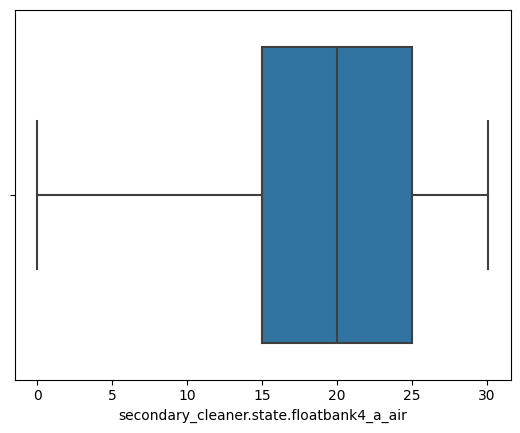

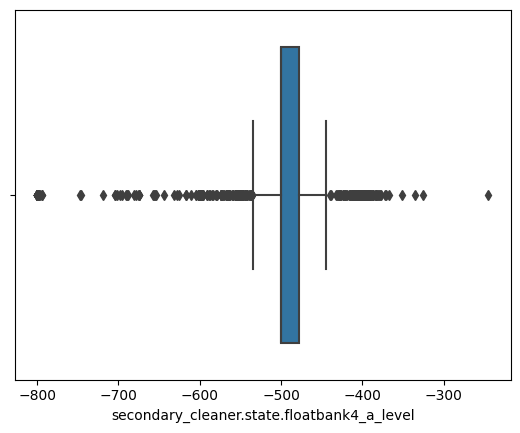

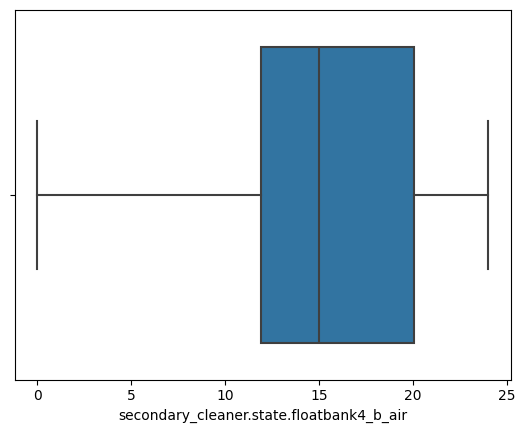

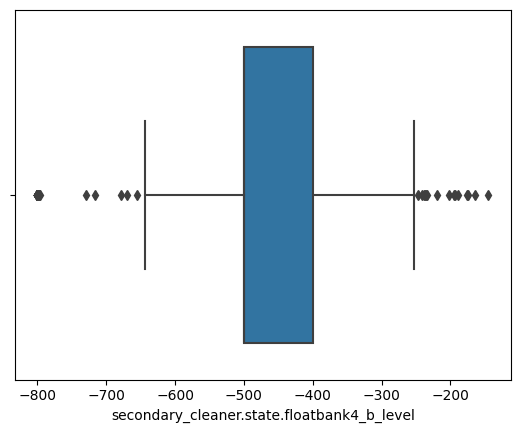

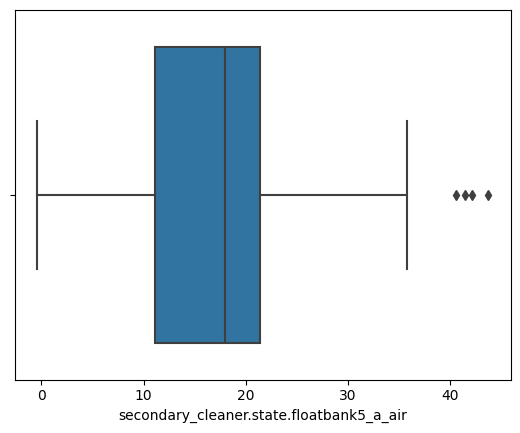

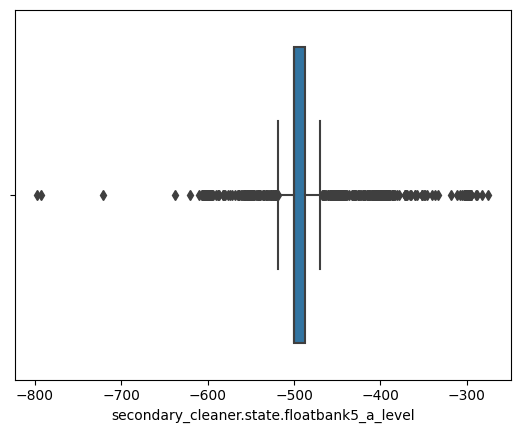

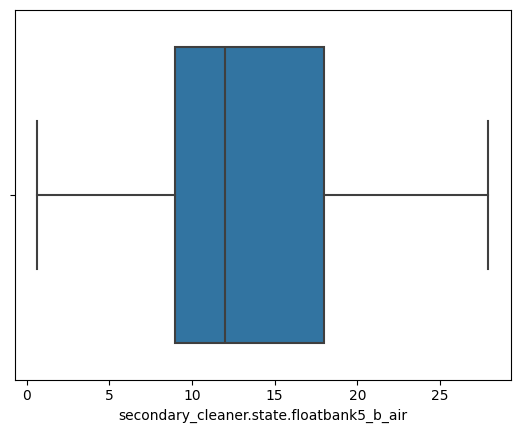

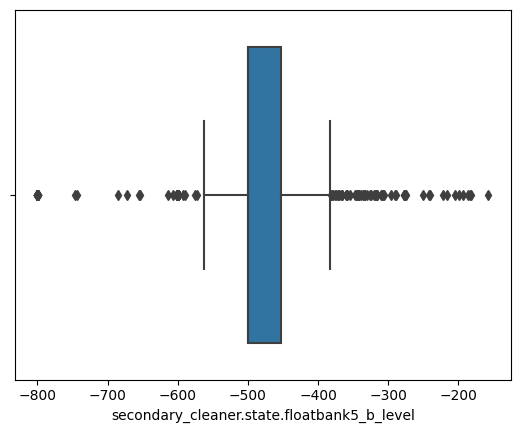

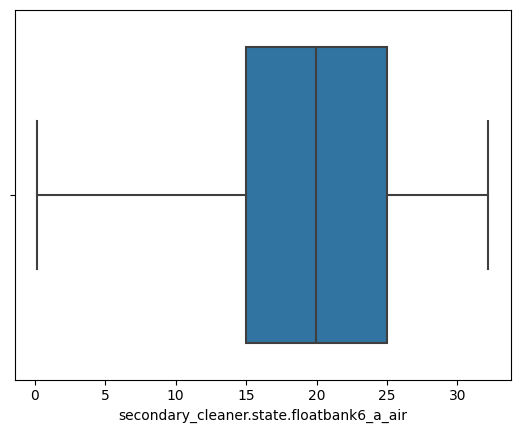

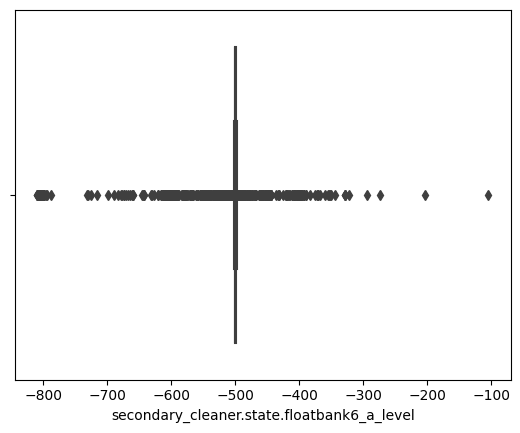

In [35]:
for column in train.drop(columns='date').columns:
    sns.boxplot(x=train[column])
    plt.show()

In [36]:
df.loc[(df['rougher.output.recovery']==0) | (df['final.output.recovery'] == 0), 
       ['date', 'rougher.output.recovery', 'final.output.recovery']] = np.nan
df.dropna(inplace=True)

In [37]:
train.loc[(train['rougher.output.recovery']==0) | (train['final.output.recovery'] == 0), 
       ['date', 'rougher.output.recovery', 'final.output.recovery']] = np.nan
train.dropna(inplace=True)

In [38]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
final.output.recovery,13795.0,66.829637,9.349648,0.168611,62.745319,67.476794,72.375516,100.000000
primary_cleaner.input.sulfate,13795.0,133.694686,39.315638,0.003112,107.636754,133.450868,159.967978,250.127834
primary_cleaner.input.depressant,13795.0,8.849619,3.374661,0.000000,6.038986,8.032148,11.420198,20.052255
primary_cleaner.input.feed_size,13795.0,7.323601,0.616106,1.080000,6.960000,7.300000,7.700000,10.470000
primary_cleaner.input.xanthate,13795.0,0.883223,0.376224,0.000005,0.606130,0.886267,1.101039,2.512968
primary_cleaner.state.floatbank8_a_air,13795.0,1607.575137,129.089592,0.006352,1594.913120,1601.839528,1699.738768,2079.531340
primary_cleaner.state.floatbank8_a_level,13795.0,-488.550969,35.993178,-798.641662,-500.286912,-499.908321,-499.368762,-330.134203
primary_cleaner.state.floatbank8_b_air,13795.0,1608.182043,131.831795,0.008700,1553.036615,1601.837968,1700.227340,2114.906758
primary_cleaner.state.floatbank8_b_level,13795.0,-488.956687,33.859650,-740.122129,-500.372727,-499.933677,-499.381943,-347.354380
primary_cleaner.state.floatbank8_c_air,13795.0,1608.562391,134.843017,0.015159,1549.143225,1601.582570,1700.471186,2013.156457


In [39]:
def iqr(data, column):
    upper = data[column].quantile(0.75)
    lower = data[column].quantile(0.25)
    iqr = upper - lower
    number = (data[column] > upper + 1.5*iqr).sum() + (data[column] < lower - 1.5*iqr).sum()
    return number

In [40]:
for column in train.drop(columns='date').columns:
    print(column, iqr(train, column))

final.output.recovery 670
primary_cleaner.input.sulfate 55
primary_cleaner.input.depressant 18
primary_cleaner.input.feed_size 252
primary_cleaner.input.xanthate 116
primary_cleaner.state.floatbank8_a_air 1364
primary_cleaner.state.floatbank8_a_level 2251
primary_cleaner.state.floatbank8_b_air 472
primary_cleaner.state.floatbank8_b_level 2369
primary_cleaner.state.floatbank8_c_air 457
primary_cleaner.state.floatbank8_c_level 3168
primary_cleaner.state.floatbank8_d_air 1136
primary_cleaner.state.floatbank8_d_level 3612
rougher.input.feed_ag 27
rougher.input.feed_pb 119
rougher.input.feed_rate 592
rougher.input.feed_size 461
rougher.input.feed_sol 489
rougher.input.feed_au 123
rougher.input.floatbank10_sulfate 361
rougher.input.floatbank10_xanthate 182
rougher.input.floatbank11_sulfate 651
rougher.input.floatbank11_xanthate 220
rougher.output.recovery 306
rougher.state.floatbank10_a_air 17
rougher.state.floatbank10_a_level 0
rougher.state.floatbank10_b_air 8
rougher.state.floatbank10_b_l

If you remove outliers using the interquartile range method, you will be left with too little data for training. Below, anomalies have been removed using the three-sigma rule.

In [41]:
for column in train.drop(columns='date').columns:
    train.loc[abs(st.zscore(train[column])) >= 3, column] = np.nan

In [42]:
train.dropna(inplace=True)
train.shape

(9999, 55)

In [43]:
for column in df.drop(columns='date').columns:
    df.loc[abs(st.zscore(df[column])) >= 3, column] = np.nan
    
df.dropna(inplace=True)
df.shape

(12000, 87)

- Gaps in data were replaced with the 'forward fill' method
- No duplicates found
- The data type of the 'date' column was replaced with 'datetime'
- The recovery metric is calculated correctly
- Features that are not in the test sample were removed from the training sample
- Data checked for multicollinearity. Decided to use a random forest model
- Zero target values have been removed from the dataset
- Data is cleaned of extremely rare outliers using the three-sigma rule

## Data analysis

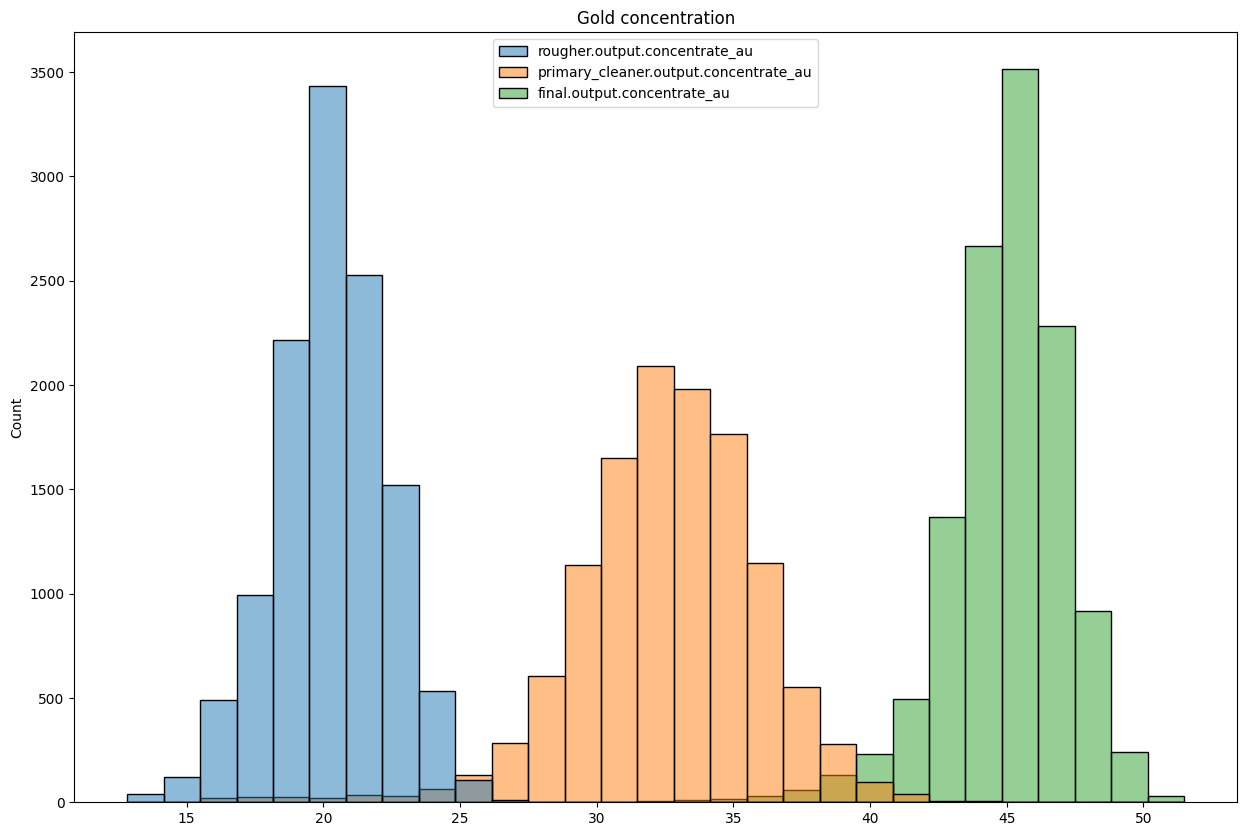

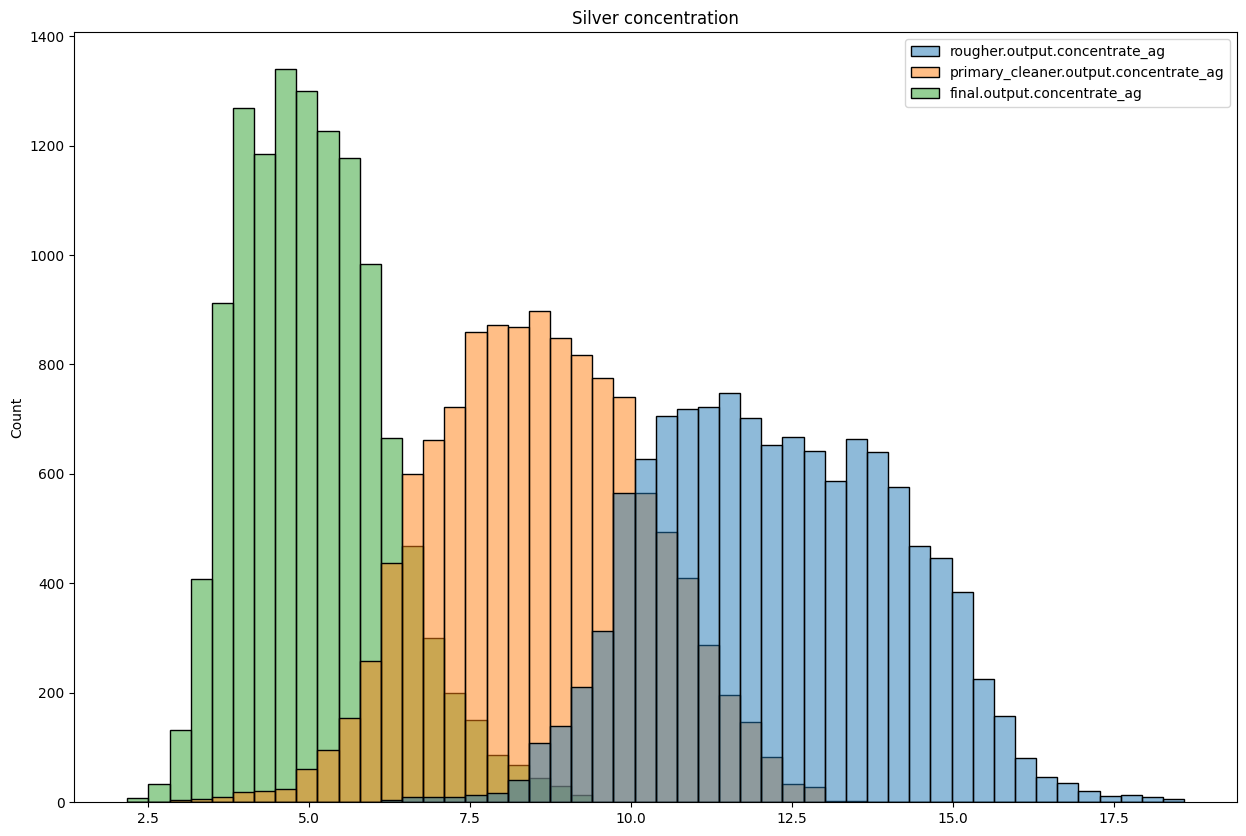

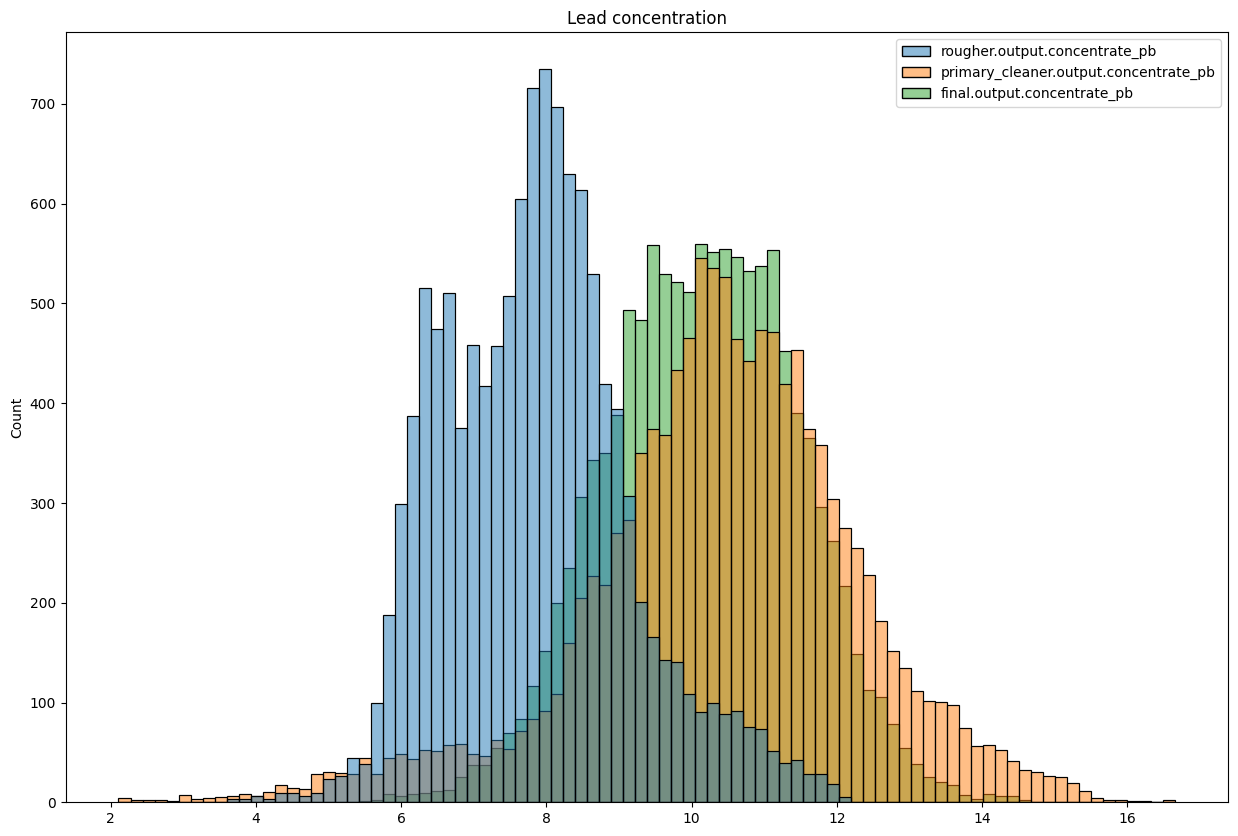

In [44]:
plt.figure(figsize=(15,10))
sns.histplot(df[['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']])
plt.title('Gold concentration')
plt.show()

plt.figure(figsize=(15, 10))
sns.histplot(df[['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']])
plt.title('Silver concentration')
plt.show()

plt.figure(figsize=(15,10))
sns.histplot(df[['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']])
plt.title('Lead concentration')
plt.show()

As can be seen from the graphs above, the concentration of gold increases with each stage of processing. The median concentration from the beginning to the end of treatment increases by at least 2 times. The silver concentration, on the contrary, decreases. The lead concentration increases after primary treatment and then decreases after secondary treatment.

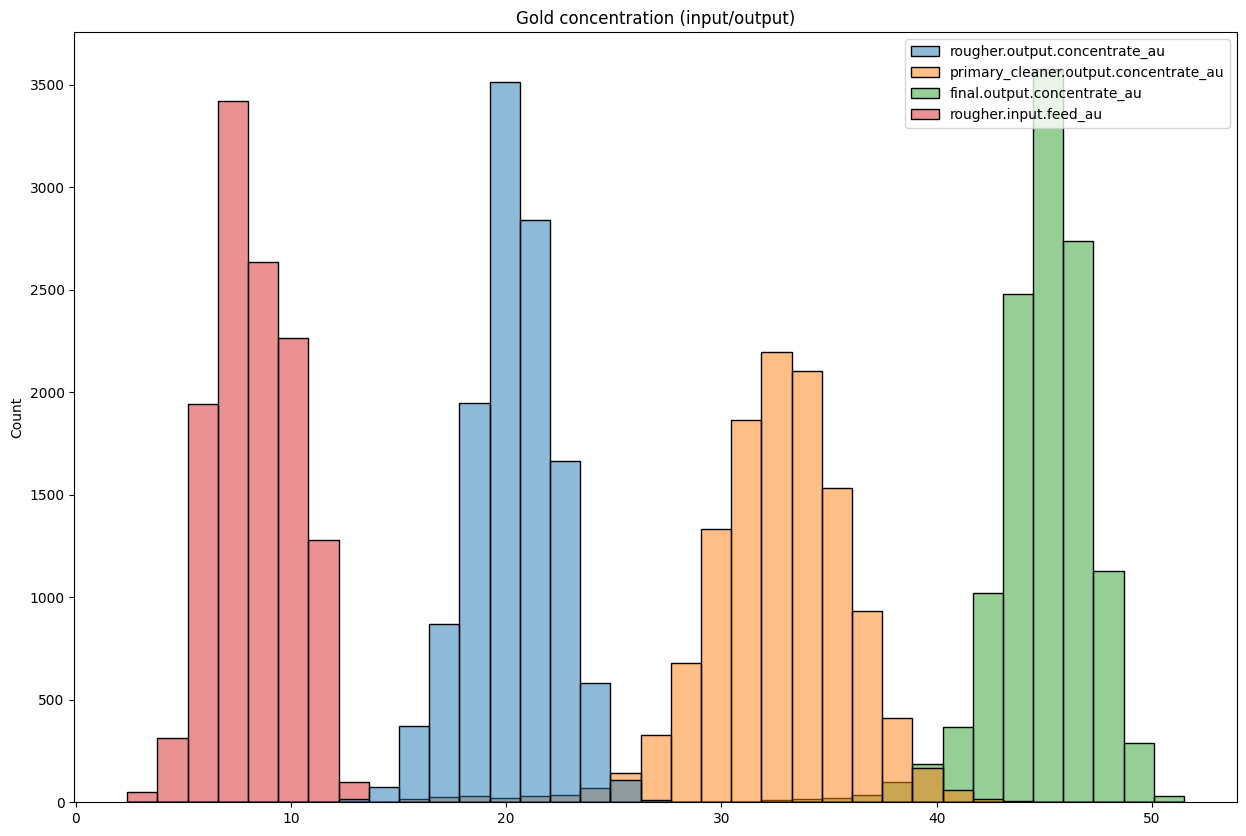

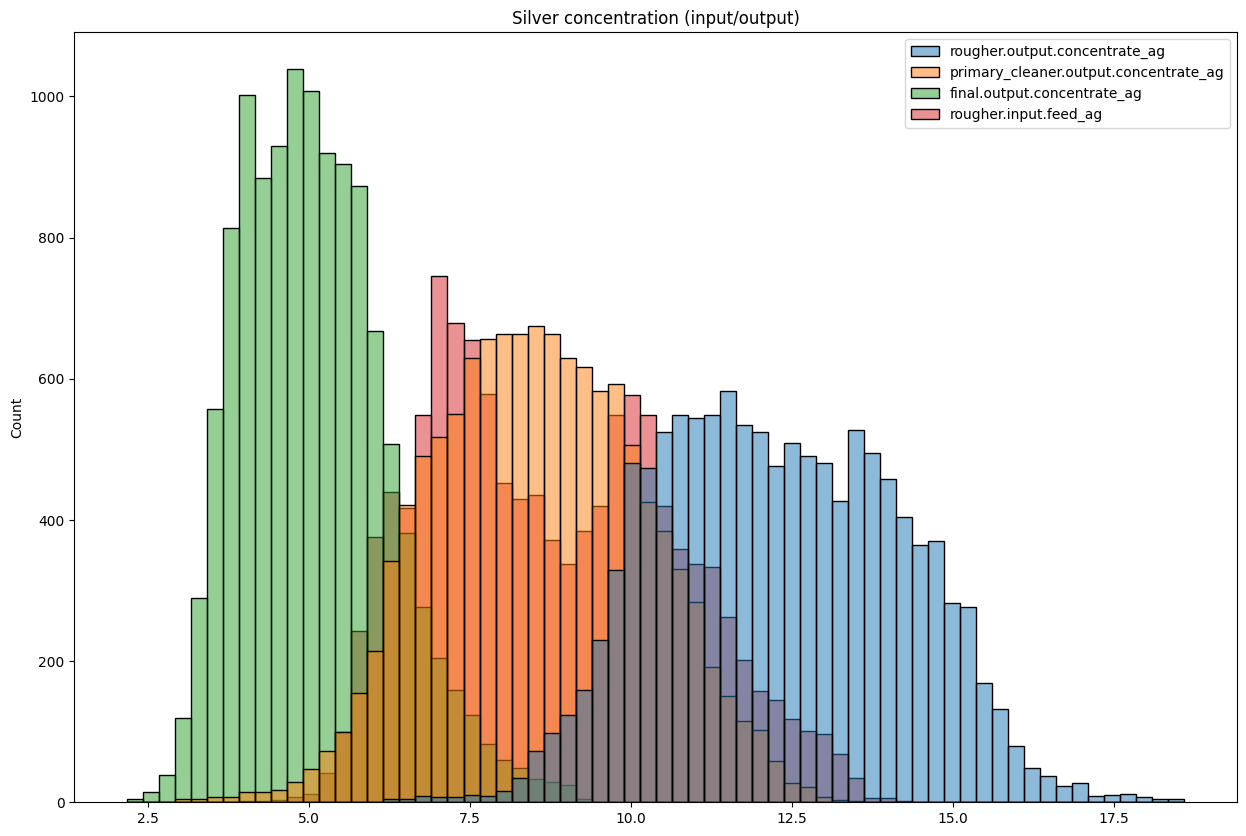

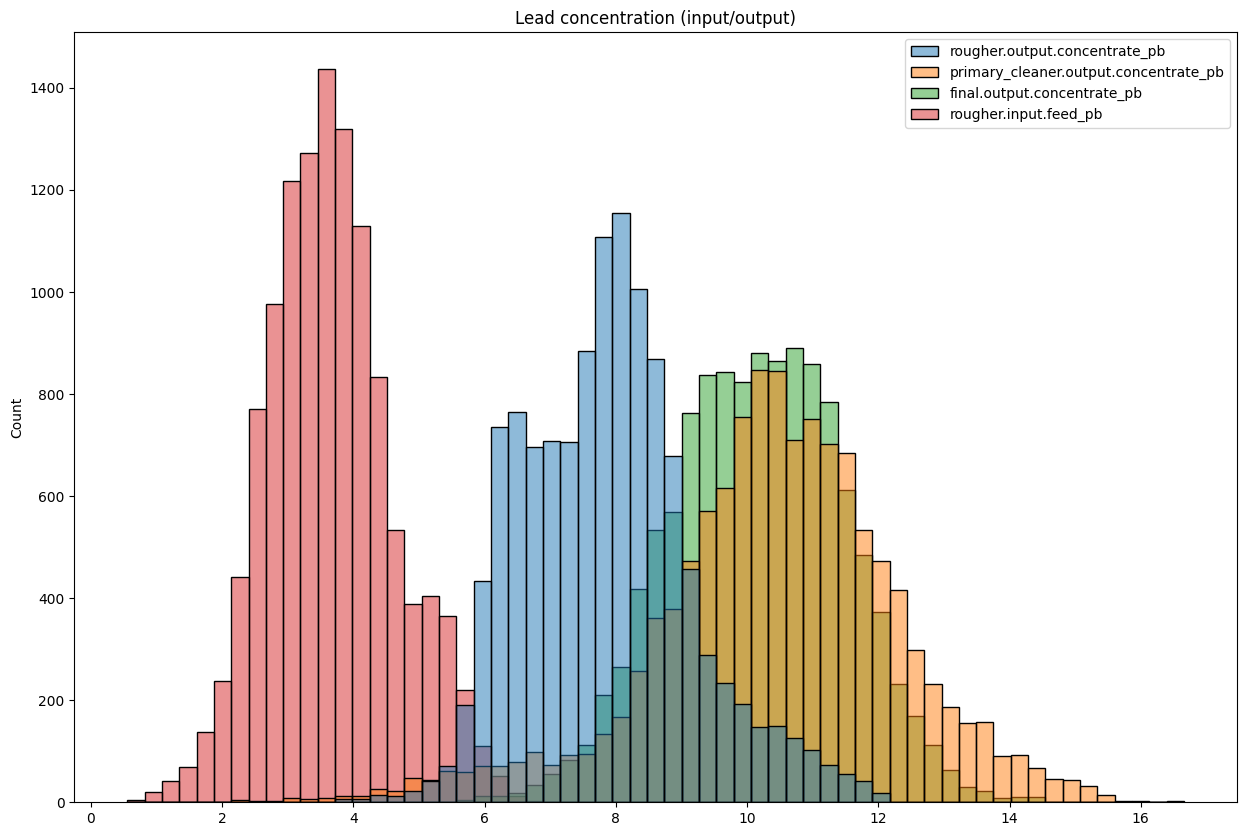

In [45]:
plt.figure(figsize=(15,10))
sns.histplot(df[['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au', 
                 'rougher.input.feed_au']])
plt.title('Gold concentration (input/output)')
plt.show()

plt.figure(figsize=(15, 10))
sns.histplot(df[['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag',
                 'rougher.input.feed_ag']])
plt.title('Silver concentration (input/output)')
plt.show()

plt.figure(figsize=(15,10))
sns.histplot(df[['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb',
                 'rougher.input.feed_pb']])
plt.title('Lead concentration (input/output)')
plt.show()

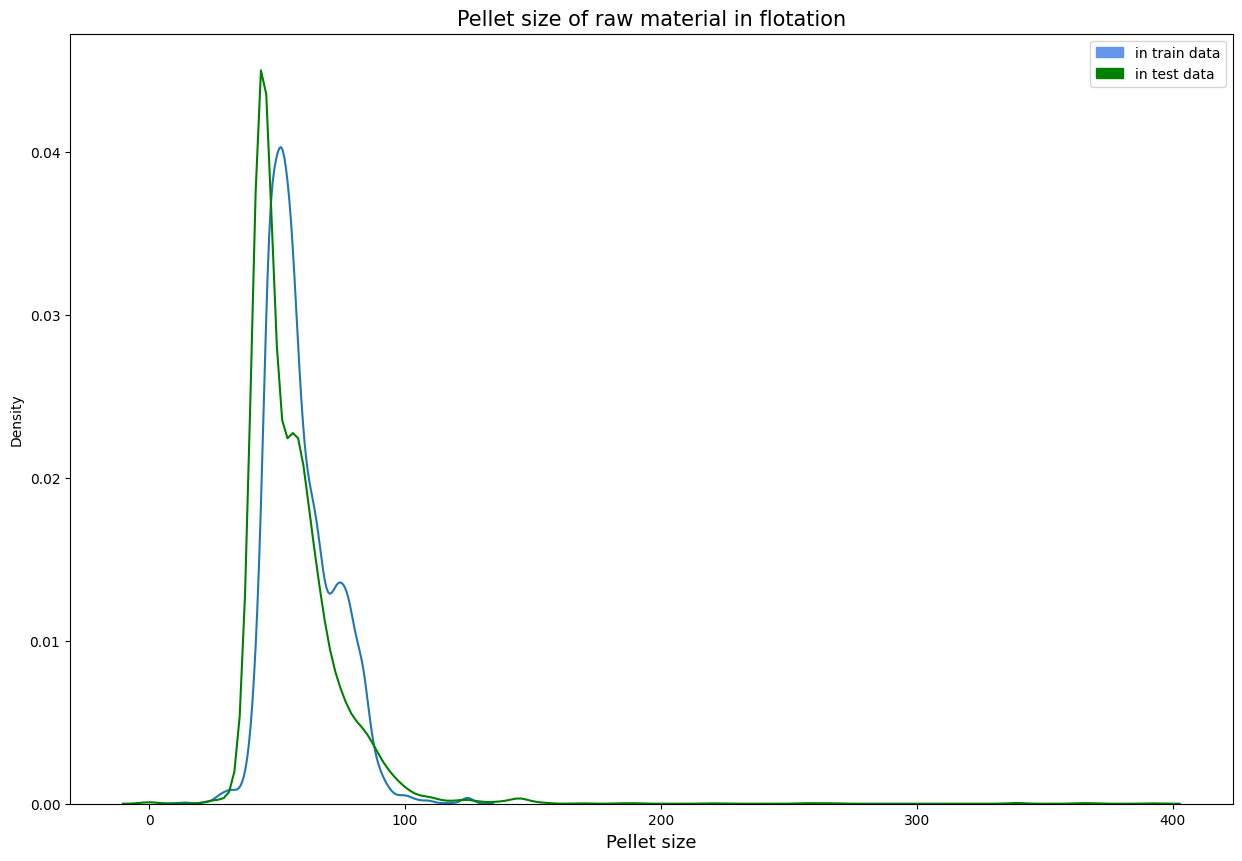

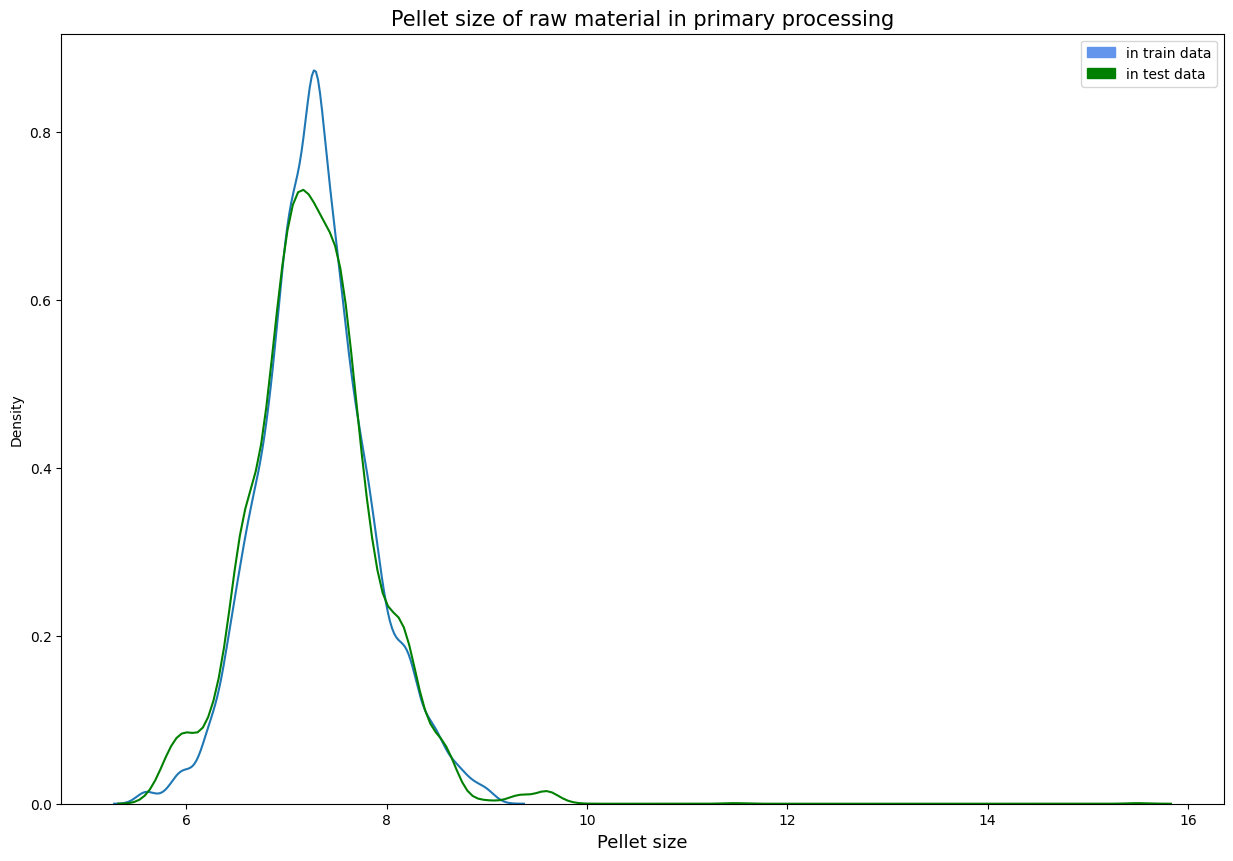

In [56]:
plt.figure(figsize=(15,10))
sns.kdeplot(train['rougher.input.feed_size'])
sns.kdeplot(test['rougher.input.feed_size'], color='green')

blue_patch = mpatches.Patch(color='cornflowerblue', label='in train data')
green_patch = mpatches.Patch(color='green', label='in test data')
plt.legend(handles=[blue_patch, green_patch])

plt.title('Pellet size of raw material in flotation', fontdict={'fontsize': 15})
plt.xlabel('Pellet size', fontsize=13)
plt.show()

plt.figure(figsize=(15,10))
sns.kdeplot(train['primary_cleaner.input.feed_size'])
sns.kdeplot(test['primary_cleaner.input.feed_size'], color='green')
plt.legend(handles=[blue_patch, green_patch])

plt.title('Pellet size of raw material in primary processing', fontdict={'fontsize': 15})
plt.xlabel('Pellet size', fontsize=13)
plt.show();

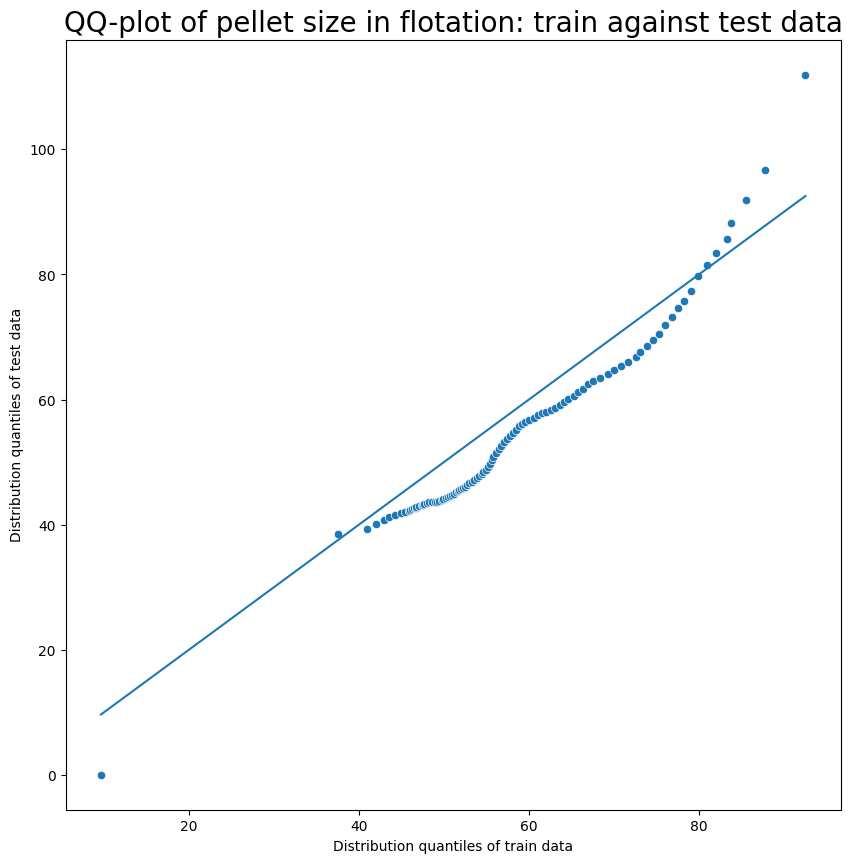

In [58]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x=np.percentile(train['rougher.input.feed_size'], range(100)), 
                y=np.percentile(test['rougher.input.feed_size'], range(100)))
sns.lineplot(x=np.percentile(train['rougher.input.feed_size'], range(100)),
             y=np.percentile(train['rougher.input.feed_size'], range(100)))
plt.title('QQ-plot of pellet size in flotation: train against test data', fontdict={'fontsize': 20})
plt.xlabel('Distribution quantiles of train data', fontsize=10)
plt.ylabel('Distribution quantiles of test data', fontsize=10);

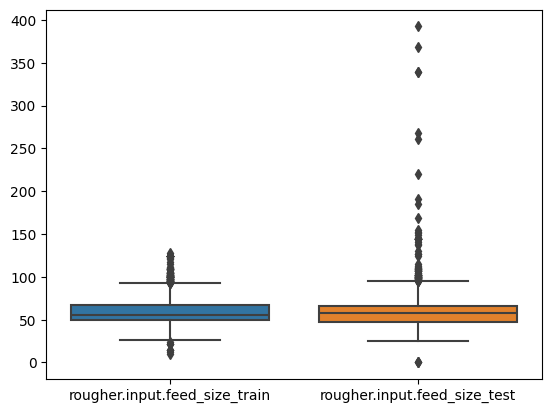

In [59]:
sns.boxplot(data=pd.DataFrame(train['rougher.input.feed_size']).join(test['rougher.input.feed_size'],
                                                                     lsuffix='_train', rsuffix='_test'));

Гранулы сырья в тестовой и тренеровочной выборке распределены примерно одинаково, qq-plot показывает неленейную зависимоть квантилей выборок. Значит, выборки немного различны по мерам размаха. Меры локации примерно равны на ящике с усами

Raw material granules in the test and training samples are distributed approximately equally, qq-plot shows a non-linear dependence of sample quantiles. This means that the samples are slightly different in terms of the scope. Location measures are approximately equal on a boxplot

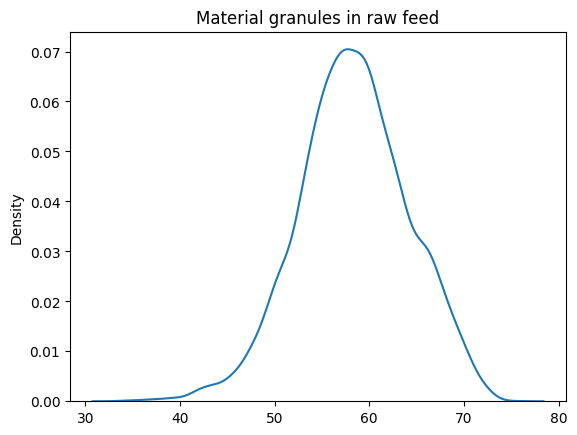

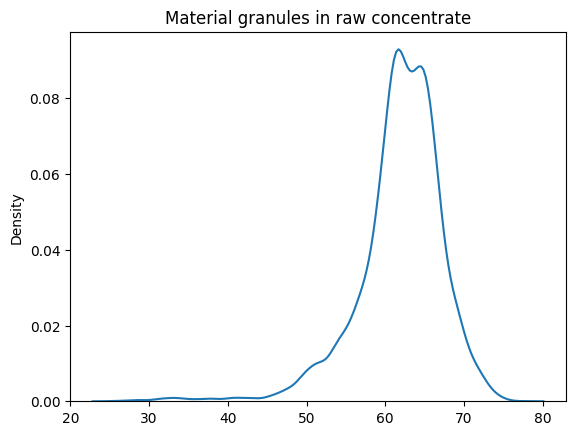

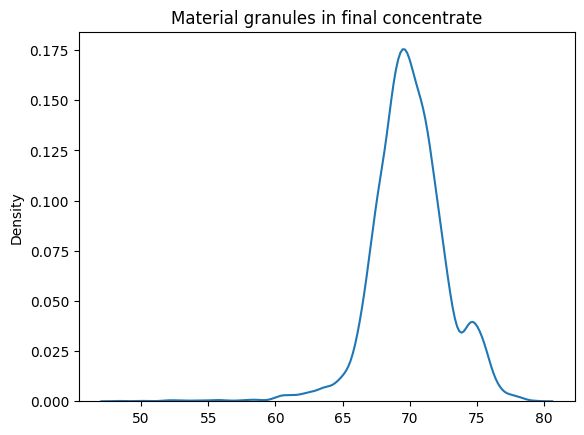

In [61]:
for i in [('rougher.input.feed_', 'in raw feed'), 
          ('primary_cleaner.output.concentrate_', 'in raw concentrate'),
          ('final.output.concentrate_', 'in final concentrate')]:
    
    sns.kdeplot((df[i[0] + 'au'] + df[i[0] + 'ag'] + df[i[0] + 'pb'] + df[i[0] + 'sol']))
    plt.title(f'Material granules {i[1]}')
    plt.show()

The graphs above show that the range of total concentrations of substances decreases as the ore is processed.

## Model

In [260]:
def smape(target, predictions):
    smape = sum(abs(target - predictions) / (abs(target) + abs(predictions))) * (200/len(target))
    return smape

t = pd.Series([1, -2, 0, -4, 5])
p = pd.Series([5, 4, -3, 0, 1])
smape(t, p)

173.33333333333331

In [261]:
def smape_total(a, b):
    smape_total = 0.25*a + 0.75*b
    return smape_total

In [262]:
smape_score = make_scorer(smape, greater_is_better=False)

In [263]:
features_train = train.drop(columns=['date', 'rougher.output.recovery', 'final.output.recovery'])
target_train = train['rougher.output.recovery'].to_numpy()

In [264]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(features_train, target_train)

cross_val_score(dummy, features_train, target_train, cv=5, scoring=smape_score).mean()

-7.170507713712482

In [265]:
forest_pipe = Pipeline([('stds', StandardScaler()), ('forest', RandomForestRegressor(random_state=12345))])

params = [{'forest__n_estimators': [10, 20],
           'forest__max_depth': [5, 6, 7],
           'forest__min_samples_leaf': [5, 10, 15]}]

gs_forest = GridSearchCV(forest_pipe,
                         param_grid=params,
                         scoring=smape_score,
                         cv=5)

gs_forest.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('stds', StandardScaler()),
                                       ('forest',
                                        RandomForestRegressor(random_state=12345))]),
             param_grid=[{'forest__max_depth': [5, 6, 7],
                          'forest__min_samples_leaf': [5, 10, 15],
                          'forest__n_estimators': [10, 20, 30, 40]}],
             scoring=make_scorer(smape, greater_is_better=False))

In [266]:
gs_forest.score(features_train, target_train)

-2.688041559064089

In [267]:
gs_forest.best_params_

{'forest__max_depth': 7,
 'forest__min_samples_leaf': 15,
 'forest__n_estimators': 10}

In [268]:
targets = test.merge(df[['rougher.output.recovery', 'final.output.recovery', 'date']],
                         how = 'inner', on= 'date')
features_test = test.merge(targets['date'], how='inner', on='date').drop(columns='date')
target_test = targets['rougher.output.recovery'].to_numpy()

In [269]:
model = LinearRegression()

scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

model.fit(features_train_scaled, target_train)

LinearRegression()

In [270]:
linreg_score = cross_val_score(model, features_train_scaled, target_train, cv=5, scoring=smape_score).mean()
linreg_score

-6.2358204399109995

In [271]:
smape_rougher = (-1)*gs_forest.score(features_test, target_test)
smape_rougher

4.2761120634604906

For the target _rougher.output.recovery_, the random forest model with the following parameters performed best: number of trees 10, tree depths up to 7, min_samples_leaf at least 15

Its sMAPE score is 2.69% versus 6.24% for linear regression on the training set. On the test sample, the random forest score is 4.28%. The model performs better than a constant model

In [272]:
target_train = train['final.output.recovery'].to_numpy()
target_test = targets['final.output.recovery'].to_numpy()

In [273]:
dummy1 = DummyRegressor(strategy='mean')
dummy1.fit(features_train, target_train)

cross_val_score(dummy1, features_train, target_train, cv=5, scoring=smape_score).mean()

-8.912540340376271

In [274]:
gs_forest1 = GridSearchCV(forest_pipe,
                         param_grid=params,
                         scoring=smape_score,
                         cv=5)

gs_forest1.fit(features_train, target_train)
gs_forest1.score(features_train, target_train)

-5.707036182963687

In [275]:
gs_forest1.best_params_

{'forest__max_depth': 5,
 'forest__min_samples_leaf': 5,
 'forest__n_estimators': 10}

In [276]:
model1 = LinearRegression()

model1.fit(features_train_scaled, target_train)

LinearRegression()

In [277]:
linreg1_score = cross_val_score(model1, features_train_scaled, target_train, cv=5, scoring=smape_score).mean()
linreg1_score

-8.713182940889117

In [278]:
smape_final = (-1)*gs_forest1.score(features_test, target_test)
smape_final

6.271967954043903

To predict the target _final.output.recovery_ it is better to take a random forest model with parameters n_estimators=10, max_depth=5, min_samples_leaf=5. Its sMAPE was 5.71% on the training set versus 8.71% for linear regression. On the test sample, the estimate was 6.27%. The model performs better than a constant model

In [279]:
smape_total = smape_total(smape_rougher, smape_final)
smape_total

5.77300398139805

Final conclusion:

Data on the parameters of gold extraction from ore were provided for analysis. It was necessary to train a model to predict the recovery rate of gold from gold ore to help the enterprise reduce losses.

- Preprocessing:

The data was cleared of outliers using the three-sigma rule, empty values ​​were replaced with the previous observation values ​​closest in date, no duplicates were found, and the accuracy of the calculations of the _recovery_ metric was checked.

- Research analysis:

The concentration of gold increases as the ore is refined, the concentration of silver gradually decreases, and the concentration of lead increases slightly. As processing proceeds, the total concentration of chemicals has a smaller range. The size of raw material granules in the training and test sets are distributed approximately equally.

- Model building:

For the _rougher.output.recovery_ forecast, the random forest performed best with the regression task, whose score on the test sample was 4.28%. For the _final.output.recovery_ forecast, linear regression performed worse than random forest. The random forest score on the test set is 6.27%. Therefore, the final score is 5.77%